<a href="https://colab.research.google.com/github/rammafitra/PyTorch_Semantic_Segmentation/blob/main/DeepLabV3_and_Lite_R_ASPP_with_MobilNetV3_Backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
url = "https://drive.google.com/uc?id=11k8fRF1CMezGlP29KPjrk1Q1gbn4YSjp&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
   f.write(r.content)

In [ ]:
!mkdir outputs

In [ ]:
!unzip input.zip

Archive:  input.zip
   creating: input/
  inflating: input/video_2.mp4       
  inflating: input/image_1.jpg       
  inflating: input/image_2.jpg       
  inflating: input/video_1.mp4       


#**Label Color Map**

In [ ]:
%%writefile label_color_map.py
label_color_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

Writing label_color_map.py


#**Segmentation Utility**

In [ ]:
%%writefile segmentation_utils.py
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch

from label_color_map import label_color_map as label_map

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def get_segment_labels(image, model, device):
    # transform the image to tensor and load into computation device
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image)
    return outputs

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()

    # create Numpy arrays containing zeros
    # later to be used to fill them with respective red, green, and blue pixels
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        red_map[index] = np.array(label_map)[label_num, 0]
        green_map[index] = np.array(label_map)[label_num, 1]
        blue_map[index] = np.array(label_map)[label_num, 2]
        
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map

def image_overlay(image, segmented_image):
    alpha = 1 # transparency for the original image
    beta = 0.8 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    return image

Writing segmentation_utils.py


#**Image Segmentation**

In [ ]:
%%writefile segment_image.py
import torchvision
import torch
import argparse
import segmentation_utils
import cv2
from PIL import Image

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image')
parser.add_argument('-m', '--model', help='name of the model to use',
                    choices=['deeplabv3', 'lraspp'], required=True)
args = vars(parser.parse_args())

# set computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model according to the --model flag
if args['model'] == 'deeplabv3':
    print('USING DEEPLABV3 WITH MOBILENETV3 BACKBONE')
    model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
elif args['model'] == 'lraspp':
    print('USING LITE R-ASPP WITH MOBILENETV3 BACKBONE')
    model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True)
# model to eval() model and load onto computation devicce
model.eval().to(device)

# read the image
image = Image.open(args['input'])
# do forward pass and get the output dictionary
outputs = segmentation_utils.get_segment_labels(image, model, device)
# get the data from the `out` key
outputs = outputs['out']
segmented_image = segmentation_utils.draw_segmentation_map(outputs)

final_image = segmentation_utils.image_overlay(image, segmented_image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}_{args['model']}"
# show the segmented image and save to disk
# cv2.imshow('Segmented image', final_image)
# cv2.waitKey(0)
cv2.imwrite(f"outputs/{save_name}.jpg", final_image)

Writing segment_image.py


In [ ]:
!python segment_image.py --input input/image_1.jpg --model deeplabv3

USING DEEPLABV3 WITH MOBILENETV3 BACKBONE
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100% 42.3M/42.3M [00:01<00:00, 26.8MB/s]


In [ ]:
!python segment_image.py --input input/image_2.jpg --model deeplabv3

USING DEEPLABV3 WITH MOBILENETV3 BACKBONE


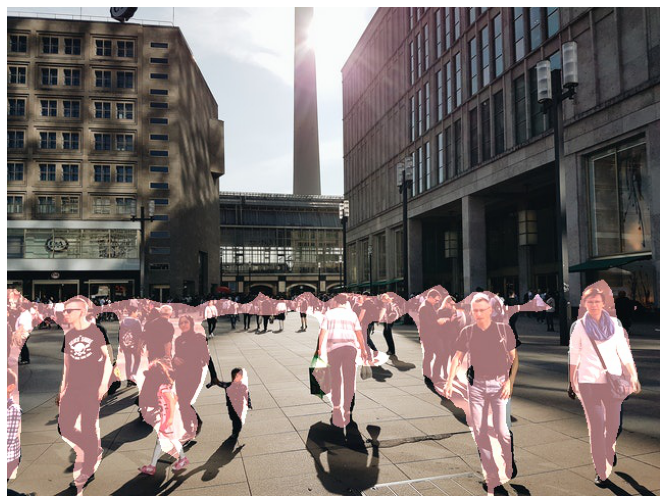

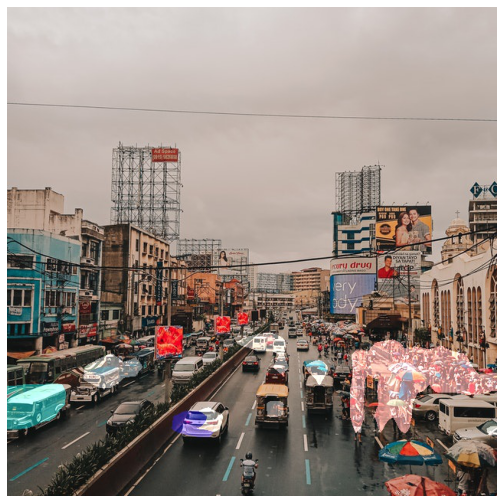

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 12, 9

image_1 = plt.imread('/content/outputs/image_1_deeplabv3.jpg')
image_2 = plt.imread('/content/outputs/image_2_deeplabv3.jpg')

plt.imshow(image_1)
plt.axis('off')
plt.show()
plt.imshow(image_2)
plt.axis('off')
plt.show()

In [ ]:
!python segment_image.py --input input/image_1.jpg --model lraspp

USING LITE R-ASPP WITH MOBILENETV3 BACKBONE
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100% 21.1M/21.1M [00:00<00:00, 97.4MB/s]
Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth
100% 12.5M/12.5M [00:00<00:00, 91.8MB/s]


In [11]:
!python segment_image.py --input input/image_2.jpg --model lraspp

USING LITE R-ASPP WITH MOBILENETV3 BACKBONE


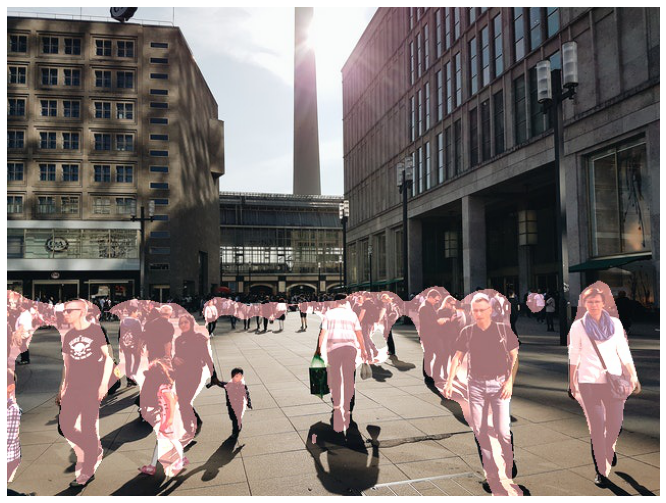

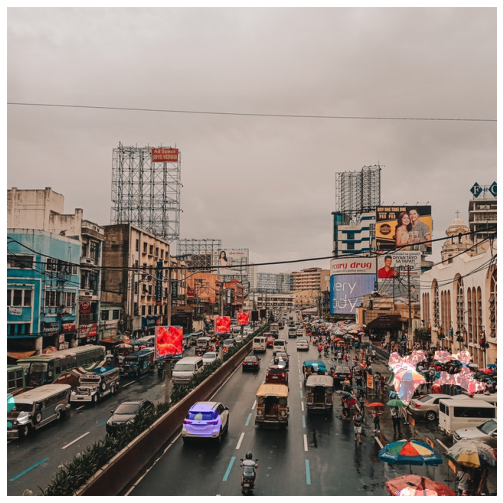

In [12]:
image_1 = plt.imread('/content/outputs/image_1_lraspp.jpg')
image_2 = plt.imread('/content/outputs/image_2_lraspp.jpg')

plt.imshow(image_1)
plt.axis('off')
plt.show()
plt.imshow(image_2)
plt.axis('off')
plt.show()

#**Semantic Segmentation in Videos**

In [13]:
%%writefile segment_video.py
import torchvision
import cv2
import torch
import argparse
import time
import segmentation_utils

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input video')
parser.add_argument('-m', '--model', help='name of the model to use',
                    choices=['deeplabv3', 'lraspp'], required=True)
args = vars(parser.parse_args())

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# download or load the model from disk
if args['model'] == 'deeplabv3':
    print('USING DEEPLABV3 WITH MOBILENETV3 BACKBONE')
    model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
elif args['model'] == 'lraspp':
    print('USING LITE R-ASPP WITH MOBILENETV3 BACKBONE')
    model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True)
# load the model onto the computation device
model = model.eval().to(device)

cap = cv2.VideoCapture(args['input'])
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

save_name = f"{args['input'].split('/')[-1].split('.')[0]}_{args['model']}"
# define codec and create VideoWriter object
out = cv2.VideoWriter(f"outputs/{save_name}.mp4",
                      cv2.VideoWriter_fourcc(*'mp4v'), 30,
                      (frame_width, frame_height))

frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # get the start time
        start_time = time.time()
        with torch.no_grad():
            # get predictions for the current frame
            outputs = segmentation_utils.get_segment_labels(rgb_frame, model, device)
        
        # obtain the segmentation map
        segmented_image = segmentation_utils.draw_segmentation_map(outputs['out'])
        # get the final image with segmentation map overlayed on original iimage
        final_image = segmentation_utils.image_overlay(rgb_frame, segmented_image)

        # get the end time
        end_time = time.time()
        # get the current fps
        fps = 1 / (end_time - start_time)
        # add current fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        print(f"Frame: {frame_count}, FPS:{fps:.3f} FPS")
        # put the FPS text on the current frame
        cv2.putText(final_image, f"{fps:.3f} FPS", (20, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # press `q` to exit
        # cv2.imshow('image', final_image)
        out.write(final_image)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
    else:
        break

# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}") 

Writing segment_video.py


In [14]:
!python segment_video.py --input input/video_1.mp4 --model deeplabv3

USING DEEPLABV3 WITH MOBILENETV3 BACKBONE
Frame: 1, FPS:15.352 FPS
Frame: 2, FPS:16.709 FPS
Frame: 3, FPS:16.712 FPS
Frame: 4, FPS:16.563 FPS
Frame: 5, FPS:18.347 FPS
Frame: 6, FPS:19.025 FPS
Frame: 7, FPS:19.283 FPS
Frame: 8, FPS:19.971 FPS
Frame: 9, FPS:20.896 FPS
Frame: 10, FPS:20.336 FPS
Frame: 11, FPS:21.056 FPS
Frame: 12, FPS:20.808 FPS
Frame: 13, FPS:20.841 FPS
Frame: 14, FPS:20.636 FPS
Frame: 15, FPS:21.100 FPS
Frame: 16, FPS:21.934 FPS
Frame: 17, FPS:22.272 FPS
Frame: 18, FPS:22.770 FPS
Frame: 19, FPS:21.475 FPS
Frame: 20, FPS:22.714 FPS
Frame: 21, FPS:22.686 FPS
Frame: 22, FPS:22.648 FPS
Frame: 23, FPS:23.101 FPS
Frame: 24, FPS:23.262 FPS
Frame: 25, FPS:22.375 FPS
Frame: 26, FPS:23.296 FPS
Frame: 27, FPS:22.713 FPS
Frame: 28, FPS:23.164 FPS
Frame: 29, FPS:23.150 FPS
Frame: 30, FPS:23.379 FPS
Frame: 31, FPS:22.026 FPS
Frame: 32, FPS:23.336 FPS
Frame: 33, FPS:23.163 FPS
Frame: 34, FPS:22.974 FPS
Frame: 35, FPS:22.387 FPS
Frame: 36, FPS:22.911 FPS
Frame: 37, FPS:21.829 FPS
Frame

In [15]:
!python segment_video.py --input input/video_2.mp4 --model deeplabv3

USING DEEPLABV3 WITH MOBILENETV3 BACKBONE
Frame: 1, FPS:16.118 FPS
Frame: 2, FPS:16.782 FPS
Frame: 3, FPS:16.998 FPS
Frame: 4, FPS:16.365 FPS
Frame: 5, FPS:16.343 FPS
Frame: 6, FPS:19.260 FPS
Frame: 7, FPS:19.681 FPS
Frame: 8, FPS:19.523 FPS
Frame: 9, FPS:20.794 FPS
Frame: 10, FPS:20.565 FPS
Frame: 11, FPS:21.172 FPS
Frame: 12, FPS:21.276 FPS
Frame: 13, FPS:22.029 FPS
Frame: 14, FPS:21.499 FPS
Frame: 15, FPS:21.966 FPS
Frame: 16, FPS:21.399 FPS
Frame: 17, FPS:21.739 FPS
Frame: 18, FPS:22.478 FPS
Frame: 19, FPS:21.414 FPS
Frame: 20, FPS:21.555 FPS
Frame: 21, FPS:22.354 FPS
Frame: 22, FPS:22.036 FPS
Frame: 23, FPS:21.370 FPS
Frame: 24, FPS:22.783 FPS
Frame: 25, FPS:23.123 FPS
Frame: 26, FPS:23.431 FPS
Frame: 27, FPS:23.324 FPS
Frame: 28, FPS:22.775 FPS
Frame: 29, FPS:23.055 FPS
Frame: 30, FPS:23.723 FPS
Frame: 31, FPS:23.938 FPS
Frame: 32, FPS:23.210 FPS
Frame: 33, FPS:23.514 FPS
Frame: 34, FPS:23.424 FPS
Frame: 35, FPS:22.424 FPS
Frame: 36, FPS:22.823 FPS
Frame: 37, FPS:23.246 FPS
Frame

In [16]:
!python segment_video.py --input input/video_1.mp4 --model lraspp

USING LITE R-ASPP WITH MOBILENETV3 BACKBONE
Frame: 1, FPS:21.407 FPS
Frame: 2, FPS:23.860 FPS
Frame: 3, FPS:23.144 FPS
Frame: 4, FPS:24.339 FPS
Frame: 5, FPS:24.653 FPS
Frame: 6, FPS:24.944 FPS
Frame: 7, FPS:24.157 FPS
Frame: 8, FPS:24.760 FPS
Frame: 9, FPS:25.089 FPS
Frame: 10, FPS:24.993 FPS
Frame: 11, FPS:25.290 FPS
Frame: 12, FPS:25.159 FPS
Frame: 13, FPS:24.345 FPS
Frame: 14, FPS:24.987 FPS
Frame: 15, FPS:24.897 FPS
Frame: 16, FPS:24.354 FPS
Frame: 17, FPS:25.407 FPS
Frame: 18, FPS:25.098 FPS
Frame: 19, FPS:23.028 FPS
Frame: 20, FPS:23.855 FPS
Frame: 21, FPS:24.895 FPS
Frame: 22, FPS:24.803 FPS
Frame: 23, FPS:24.828 FPS
Frame: 24, FPS:25.085 FPS
Frame: 25, FPS:25.229 FPS
Frame: 26, FPS:25.377 FPS
Frame: 27, FPS:24.096 FPS
Frame: 28, FPS:25.138 FPS
Frame: 29, FPS:25.055 FPS
Frame: 30, FPS:25.273 FPS
Frame: 31, FPS:25.390 FPS
Frame: 32, FPS:25.570 FPS
Frame: 33, FPS:24.060 FPS
Frame: 34, FPS:24.829 FPS
Frame: 35, FPS:24.961 FPS
Frame: 36, FPS:25.350 FPS
Frame: 37, FPS:25.468 FPS
Fra

In [17]:
!python segment_video.py --input input/video_2.mp4 --model lraspp

USING LITE R-ASPP WITH MOBILENETV3 BACKBONE
Frame: 1, FPS:21.939 FPS
Frame: 2, FPS:24.450 FPS
Frame: 3, FPS:24.433 FPS
Frame: 4, FPS:25.786 FPS
Frame: 5, FPS:24.978 FPS
Frame: 6, FPS:25.101 FPS
Frame: 7, FPS:23.860 FPS
Frame: 8, FPS:24.767 FPS
Frame: 9, FPS:25.231 FPS
Frame: 10, FPS:25.323 FPS
Frame: 11, FPS:24.444 FPS
Frame: 12, FPS:25.228 FPS
Frame: 13, FPS:24.286 FPS
Frame: 14, FPS:25.003 FPS
Frame: 15, FPS:25.124 FPS
Frame: 16, FPS:25.284 FPS
Frame: 17, FPS:24.906 FPS
Frame: 18, FPS:25.763 FPS
Frame: 19, FPS:24.130 FPS
Frame: 20, FPS:25.366 FPS
Frame: 21, FPS:24.314 FPS
Frame: 22, FPS:25.549 FPS
Frame: 23, FPS:25.615 FPS
Frame: 24, FPS:25.337 FPS
Frame: 25, FPS:25.600 FPS
Frame: 26, FPS:25.463 FPS
Frame: 27, FPS:25.220 FPS
Frame: 28, FPS:25.078 FPS
Frame: 29, FPS:24.873 FPS
Frame: 30, FPS:25.610 FPS
Frame: 31, FPS:24.949 FPS
Frame: 32, FPS:23.656 FPS
Frame: 33, FPS:24.819 FPS
Frame: 34, FPS:24.811 FPS
Frame: 35, FPS:24.947 FPS
Frame: 36, FPS:24.735 FPS
Frame: 37, FPS:24.838 FPS
Fra

In [18]:
from google.colab import files
!zip -r /content/outputs outputs
files.download('/content/outputs.zip')

  adding: outputs/ (stored 0%)
  adding: outputs/video_1_deeplabv3.mp4 (deflated 1%)
  adding: outputs/video_2_deeplabv3.mp4 (deflated 1%)
  adding: outputs/video_2_lraspp.mp4 (deflated 1%)
  adding: outputs/video_1_lraspp.mp4 (deflated 1%)
  adding: outputs/image_1_lraspp.jpg (deflated 2%)
  adding: outputs/image_1_deeplabv3.jpg (deflated 2%)
  adding: outputs/image_2_lraspp.jpg (deflated 3%)
  adding: outputs/image_2_deeplabv3.jpg (deflated 2%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>